# SVM y Kernels

En clases discutimos el algoritmo de SVM para hacer clasificación binaria de un _dataset_. Además vimos cómo lo hacía este algoritmo para trabajar con _datasets_ que no son linealmente separables. En este _notebook_ vamos a aprender a usar las funciones de la librería Scikit Learn para SVM. Vamos a partir con clasificación _soft margin_ para después seguir con clasificación basada en _Kernels_.

## Soft Margin SVM

En clasess aprendimos que al relajar el problema de optimización, podíamos tolerar errores en el margen de nuestra clasificación. Esto nos servía para separar _datasets_ que no eran linealmente separables, además de manejar mejor los _outliers_. Vamos a trabajar con el _dataset_ de las flores Iris.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]  # Largo del pétalo y ancho del pétalo
y = (iris['target'] == 2).astype(np.float64)  # Queremos dejar como True las Iris Virginica

# Creamos el clasificador
svm_clf = LinearSVC(C=1, loss='hinge')
# svm_clf = LinearSVC(C=100, loss="hinge", max_iter=2000)

# Vamos a crear un Pipeline, porque SVM funciona mejor cuando escalamos los datos
# Linear SVC es un Support Vector Classifier que solamente hace clasificación lineal
scaler = StandardScaler()

scaled_svm_clf = Pipeline([
        ('scaler', scaler),
        ('linear_svc', svm_clf),
    ])

scaled_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

Ahora que tenemos nuestro clasificador, vamos a ver su frontera de decisión.

(4.0, 6.0, 0.8, 2.8)

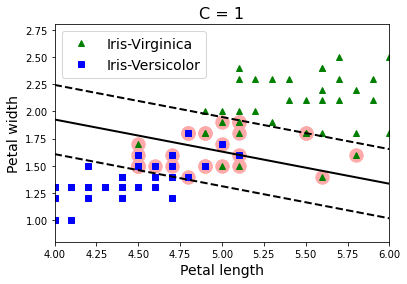

In [3]:
import matplotlib.pyplot as plt

# Código para encontrar la frontera de decisión de un SVM escalado
b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])
w = svm_clf.coef_[0] / scaler.scale_
svm_clf.intercept_ = np.array([b])
svm_clf.coef_ = np.array([w])

# Código para encontrar los vectores de soporte
t = y * 2 - 1
support_vectors_idx = (t * (X.dot(w) + b) < 1).ravel()
svm_clf.support_vectors_ = X[support_vectors_idx]

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # En la frontera de decisión tenemos: w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, 'k-', linewidth=2)
    plt.plot(x0, gutter_up, 'k--', linewidth=2)
    plt.plot(x0, gutter_down, 'k--', linewidth=2)

plt.figure()
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^', label='Iris-Virginica')
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs', label='Iris-Versicolor')
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.title(f'C = {svm_clf.C}', fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

Aquí vemos donde están los vectores de soporte y los puntos dentro del margen para este problema. Ahora es el momento de ver cómo podemos aplicar el truco del kernel en Scikit Learn

## Uso de Kernel en SVM

Para usar el truco del Kernel en la implementación de SVM de Scikit Learn, vamos a importar la clase `SVC` (Support Vector Classifier) y vamos a entregar los parámetros correspondiente. Para esto vamos a generar un _dataset_ con la función `make_moons` de Scikit Learn, que nos genera dos "semicírculos" para poder ver cómo se comportan clasificadores con fronteras de decisión no lineales.

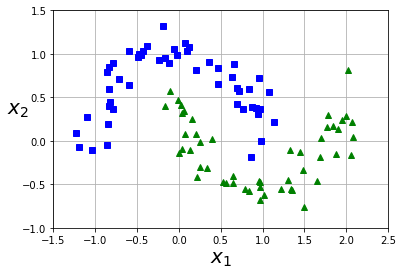

In [4]:
from sklearn.datasets import make_moons

# Generamos y visualizamos el dataset
X, y = make_moons(n_samples=100, noise=0.15)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^')
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r'$x_1$', fontsize=20)
    plt.ylabel(r'$x_2$', fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Ahora vamos a entrenar a nuestro clasificador con un Kernel polinomial de grado 3.

In [5]:
from sklearn.svm import SVC

# Nuevamente escalamos nuestro dataset, y luego usamos un kernel polinomial de grado 3 y término independiente 1

poly_kernel_svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

Y ahora graficaremos las fronteras de decisión.

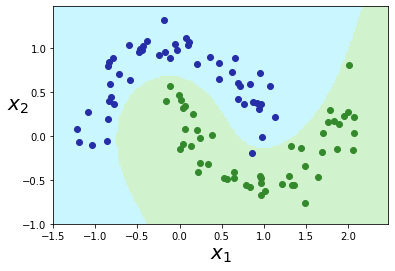

In [6]:
from matplotlib.colors import ListedColormap

# Generamos las combinaciones de x/y del plano en los rangos

x_min = -1.5
x_max = 2.5
y_min = -1.0
y_max = 1.5

cmap_light = ListedColormap(['#c9f6ff', '#d0f2cd'])
cmap_bold = ['#262ea7', '#34892d']

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = poly_kernel_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Resultado de la frontera de decisión con color claro
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(X[y==0, 0], X[y==0, 1], c=cmap_bold[0])
plt.scatter(X[y==1, 0], X[y==1, 1], c=cmap_bold[1])
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20, rotation=0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

¿Pero qué pasa cuando lo intentamos con el Kernel RBF? Recordemos que este Kernel es el resultado del producto punto entre dos elementos que fueron transformado a un espacio de infinitas dimensiones. Vamos a ver como se comporta a la hora de clasificar nuestro dataset.

In [11]:
# Nuevamente escalamos nuestro dataset, y luego usamos un kernel rbf con gamma 5

# Aquí tenemos hartas opciones para probar

svm_instance = SVC(kernel='rbf', gamma=0.1, C=0.1)
# svm_instance = SVC(kernel="rbf", gamma=0.1, C=1000)
# svm_instance = SVC(kernel="rbf", gamma=5, C=0.001)

rbf_kernel_svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', svm_instance),
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.1, gamma=0.1))])

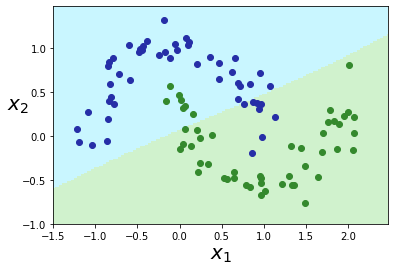

In [12]:
x_min = -1.5
x_max = 2.5
y_min = -1.0
y_max = 1.5

cmap_light = ListedColormap(['#c9f6ff', '#d0f2cd'])
cmap_bold = ['#262ea7', '#34892d']

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = rbf_kernel_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Resultado de la frontera de decisión con color claro
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(X[y==0, 0], X[y==0, 1], c=cmap_bold[0])
plt.scatter(X[y==1, 0], X[y==1, 1], c=cmap_bold[1])
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20, rotation=0)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Pero como vemos, hay varios hiperparámetros que uno podría modificar para obtener distintos resultados. En este caso, `gamma` y `C` son valores que el modelo no aprende, y que en cambio tenemos que escoger nosotros. ¿Cómo podemos saber que valores son los mejores? Para esto hay varias técnicas, pero en general, uno debe hacer una búsqueda de los parámetros que son más útiles para lo que estamos haciendo. Una forma fácil de hacer esto en Scikit Learn es con la función `SearchGrid`. A este función le indicamos los posibles valores que nos interesa probar para los hiperparámetros, y automáticamente prueba todas las combinaciones posibles. En cada prueba, evalúa el modelo con _cross-validation_ y se queda con la combinación de hiperparámetros que tuvo mejor desempeño. En general, para probar nuestro modelo después de este proceso, tenemos que usar un conjunto aparte de prueba (por ejemplo, para evitar probar con algo que hemos visto antes).

In [19]:
from sklearn.model_selection import GridSearchCV

# Creamos la lista de hiperparámetros que queremos probar
# Ojo que el svm_clf que va como prefijo a las llaves del diccionario
# Vienen del nombre que tiene en el Pipeline el clasificador svm
# Después de los dos __ viene el nombre del hiperparámetro


param_grid = {
    'svm_clf__C': [0.001, 10, 1000],
    'svm_clf__gamma': [0.1, 1, 5, 10],
}

svm_instance = SVC(kernel='rbf')
validate_svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', svm_instance),
    ])

search = GridSearchCV(validate_svm_clf, param_grid, n_jobs=-1, cv=5) # No usaremos paralelísmo y haremos 5-fold cross-validation
search.fit(X, y) # Ojo, el fit es sobre el objeto GridSearch

print('Best parameter (CV score=%0.3f):' % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.980):
{'svm_clf__C': 0.001, 'svm_clf__gamma': 5}


En el ejemplo anterior estamos imprimiendo los valores que encontró la búsqueda. Ojo que tomar todas las combinaciones puede tomar un tiempo considerable, es por eso que decidimos fijar el kernel. Hay que recordar que además estamos haciendo _cross-validation_ para cada combinación de parámetros.

Ahora, ¿qué pasa si queremos hacer clasificación multiclase? ¿es útil SVM para hacer regresión? Eso lo vamos a responder en el siguiente _notebook_